# **Project UTS Visi Komputer**

## **Banana Ripeness Detection**

#### **Importing Libraries**

In [22]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Tingkat Kematangan: Matang

Persentase tiap kategori:
Mentah: 1.58%
Matang: 26.95%
Terlalu Matang: 3.03%


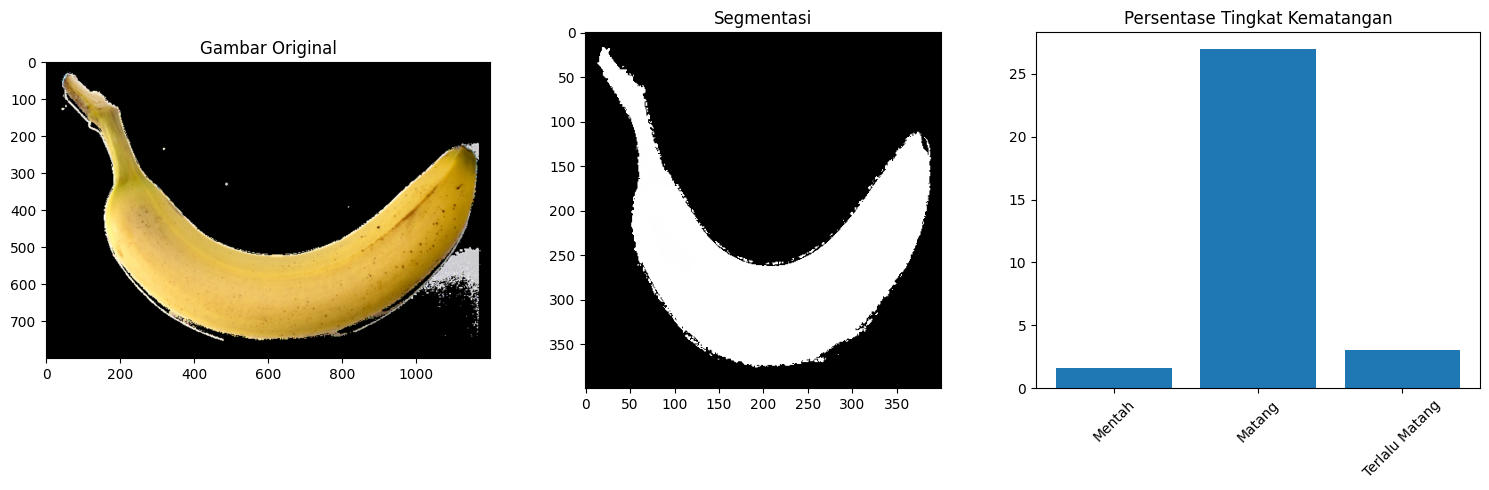

In [23]:
class BananaRipenessDetector:
    def __init__(self):
        # Definisi range warna untuk berbagai tingkat kematangan
        # HSV ranges untuk pisang
        self.unripe_range = {
            'lower': np.array([25, 50, 50]),
            'upper': np.array([35, 255, 255])  # Hijau kekuningan
        }
        self.ripe_range = {
            'lower': np.array([20, 100, 100]),
            'upper': np.array([30, 255, 255])  # Kuning
        }
        self.overripe_range = {
            'lower': np.array([0, 50, 20]),
            'upper': np.array([20, 255, 255])  # Coklat kehitaman
        }

    def preprocess_image(self, image):
        """Preprocesses the image for better detection."""
        # Resize image untuk konsistensi
        resized = cv2.resize(image, (400, 400))
        # Applying Gaussian blur untuk mengurangi noise
        blurred = cv2.GaussianBlur(resized, (5, 5), 0)
        # Konversi ke HSV color space
        hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
        return hsv

    def create_mask(self, hsv_image, lower_range, upper_range):
        """Creates a mask for specific color range."""
        mask = cv2.inRange(hsv_image, lower_range, upper_range)
        return mask

    def calculate_color_percentage(self, mask):
        """Calculates the percentage of pixels in the mask."""
        total_pixels = mask.shape[0] * mask.shape[1]
        white_pixels = cv2.countNonZero(mask)
        return (white_pixels / total_pixels) * 100

    def extract_dominant_colors(self, image, n_colors=3):
        """Extracts dominant colors using K-means clustering."""
        # Reshape image untuk K-means
        pixels = image.reshape(-1, 3)
        # Aplikasikan K-means clustering
        kmeans = KMeans(n_clusters=n_colors, random_state=42)
        kmeans.fit(pixels)
        # Dapatkan warna dominan
        colors = kmeans.cluster_centers_
        return colors.astype(int)

    def detect_ripeness(self, image_path):
        """Main function to detect banana ripeness."""
        # Baca gambar
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError("Tidak dapat membaca gambar")

        # Preprocess gambar
        hsv_image = self.preprocess_image(image)

        # Buat masks untuk setiap tingkat kematangan
        unripe_mask = self.create_mask(hsv_image, self.unripe_range['lower'], self.unripe_range['upper'])
        ripe_mask = self.create_mask(hsv_image, self.ripe_range['lower'], self.ripe_range['upper'])
        overripe_mask = self.create_mask(hsv_image, self.overripe_range['lower'], self.overripe_range['upper'])

        # Hitung persentase untuk setiap tingkat kematangan
        unripe_percentage = self.calculate_color_percentage(unripe_mask)
        ripe_percentage = self.calculate_color_percentage(ripe_mask)
        overripe_percentage = self.calculate_color_percentage(overripe_mask)

        # Ekstrak warna dominan untuk analisis tambahan
        dominant_colors = self.extract_dominant_colors(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))

        # Tentukan tingkat kematangan berdasarkan persentase tertinggi
        percentages = {
            'Mentah': unripe_percentage,
            'Matang': ripe_percentage,
            'Terlalu Matang': overripe_percentage
        }
        ripeness = max(percentages.items(), key=lambda x: x[1])[0]

        return {
            'ripeness': ripeness,
            'percentages': percentages,
            'dominant_colors': dominant_colors
        }

    def visualize_results(self, image_path, results):
        """Visualizes the detection results."""
        image = cv2.imread(image_path)
        hsv_image = self.preprocess_image(image)

        # Plot hasil
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(131)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Gambar Original')
        
        # Mask visualization
        plt.subplot(132)
        masks = []
        if results['percentages']['Mentah'] > 0:
            masks.append(self.create_mask(hsv_image, self.unripe_range['lower'], self.unripe_range['upper']))
        if results['percentages']['Matang'] > 0:
            masks.append(self.create_mask(hsv_image, self.ripe_range['lower'], self.ripe_range['upper']))
        if results['percentages']['Terlalu Matang'] > 0:
            masks.append(self.create_mask(hsv_image, self.overripe_range['lower'], self.overripe_range['upper']))
        
        combined_mask = sum(masks)
        plt.imshow(combined_mask, cmap='gray')
        plt.title('Segmentasi')
        
        # Percentages bar plot
        plt.subplot(133)
        plt.bar(results['percentages'].keys(), results['percentages'].values())
        plt.title('Persentase Tingkat Kematangan')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()

# Contoh penggunaan
if __name__ == "__main__":
    detector = BananaRipenessDetector()
    
    # Meminta pengguna memasukkan path gambar pisang yang ingin dianalisis
    image_path = input("Masukkan path gambar pisang yang ingin dianalisis: ")
    
    try:
        results = detector.detect_ripeness(image_path)
        print(f"Tingkat Kematangan: {results['ripeness']}")
        print("\nPersentase tiap kategori:")
        for category, percentage in results['percentages'].items():
            print(f"{category}: {percentage:.2f}%")
            
        detector.visualize_results(image_path, results)
        
    except Exception as e:
        print(f"Error: {str(e)}")
